In [1]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np
import statistics

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

### Exercise 1: Game Fun: Customer Acquisition through Digital Advertising

New customer subscription brings a revenue of $37.5

**Experiment:** Game Fun chose two different websites to run the experiment on. The websites have randomly assigned their web users to test and control groups. If the user qualified for a Game-Fun ad, then the ad server checked whether the user was assigned to the test or the control group. If test, a Game-Fun ad was displayed. otherwise, a irrelevant ad was displayed.

**Concerns:** Game-Fun had to pay the content publisher for the irrelevant ads, as well. Some users who saw an irrelevant ad might have signed up if they been shown their gaming ad.

- 70% test, 30% control group

In [228]:
gamefun = pd.read_excel('/Users/joaopedro/Documents/MSBA/Classes/BAX 423 - Big Data Analytics/Assignments/01./AB Analysis.xlsx')
gamefun.head()

,id,test,purchase,site,impressions,income,gender,gamer
0,1956,0,0,site1,0,100,1,0
1,45821,1,0,site1,20,70,1,0
2,59690,1,0,site1,22,100,1,0
3,18851,0,0,site1,13,90,1,0
4,60647,1,0,site1,12,60,1,0


In [16]:
gamefun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40048 entries, 0 to 40047
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           40048 non-null  int64 
 1   test         40048 non-null  int64 
 2   purchase     40048 non-null  int64 
 3   site         40048 non-null  object
 4   impressions  40048 non-null  int64 
 5   income       40048 non-null  int64 
 6   gender       40048 non-null  int64 
 7   gamer        40048 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


- Each row in the data belongs to an individual customer. 

- The first column is the anonymized customer id. 

- The second column, “test”, indicates whether the user was part of the treatment group (test =1) or the control group (test=0). 

- There are three demographic variables, “gender” (male =1, female =0), “income” (this is measured in thousands), and “gamer” (gamer = 1, if user is a gaming enthusiast; 0, otherwise). 

- The website that a customer visited is in the variable “site”. The variable “impressions” contains the number of advertising impressions that a customer received. 

- If a customer is in the test group, then all of this customer’s impressions are for the Game-Fun’s ad; if a customer is in the control group, then all of this customer’s impressions are for the irrelevant ad. 

- Last, the column “purchase” is the dependent variable, and it indicates if the customer purchased anything within 30 days after her/his conversation to the game (30 days is the expected customer lifetime duration for a mobile gamer). If a customer purchased, then purchased =1; 0, otherwise.

Before evaluating the effect of an experiment, it is important to make sure that the experiment was executed correctly. 

### 1. Check whether the test and control groups are probabilistically equivalent on their observables.

#### a) Compare the averages of the income, gender and gamer variables in the test and control groups. You should also report the % difference in the averages. Compute its statistical significance.

In [4]:
# Creating test and control dfs
test = gamefun[gamefun['test'] == 1]
control = gamefun[gamefun['test'] == 0]

print(len(test)/len(gamefun))
print(len(control)/len(gamefun))

0.7014332800639232
0.2985667199360767


In [5]:
# Compare income
avg_income_test = round(test['income'].mean(),2)
avg_income_control = round(control['income'].mean(),2)
dif_income_test_control = round(((avg_income_test-avg_income_control)/avg_income_control),3)

print(f'AVG INCOME TEST: {avg_income_test}')
print(f'AVG INCOME CONTROL: {avg_income_control}')
print(f'% DIF: {dif_income_test_control}')

AVG INCOME TEST: 54.94
AVG INCOME CONTROL: 55.17
% DIF: -0.004


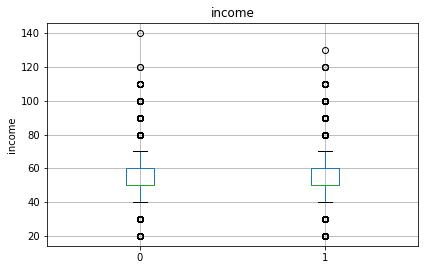

In [20]:
# Boxplots
ax = gamefun.boxplot(by = 'test', column = 'income')
ax.set_xlabel("")
ax.set_ylabel('income')
plt.suptitle("")

plt.tight_layout()
plt.show()

The results seems to be similar. To be sure we will conduct test.

- Objective: test if the mean of the income in test group is different from the control group

- Significance level: 0.05

- Test Statistic: T-test

- H0: incomes are equal

- H1: incomes are not equal

In [21]:
# T-test
tstat, pvalue, df = sm.stats.ttest_ind(
    gamefun[gamefun['test'] == 0].income, 
    gamefun[gamefun['test'] == 1].income,
    alternative='two-sided')

print(f'p-value: {pvalue:.4f}')

p-value: 0.1284


Since p-value is greater than the significance level, we fail to reject the null hypothesis. We don't have enough information to say the incomes are different.

Next we will test the gender proportion

In [62]:
# Compare Gender Proportion
test_m_num = test[test['gender'] == 1]['gender'].value_counts()
test_f_num = test[test['gender'] == 0]['gender'].value_counts()
test_m_prop = round(test_m_num[1]/(test_m_num[1]+test_f_num[0]),4)

control_m_num = control[control['gender'] == 1]['gender'].value_counts()
control_f_num = control[control['gender'] == 0]['gender'].value_counts()
control_m_prop = round(control_m_num[1]/(control_m_num[1]+control_f_num[0]),4)

print(f'TEST MALE PROP: {test_m_prop}')
print(f'CONTROL MALE PROP: {control_m_prop}')

TEST MALE PROP: 0.6473
CONTROL MALE PROP: 0.6479


The proportion male/female is extremely close between the groups. We can conduct a prop test to be sure

- Objective: test if the proportion male/female in the test group is the same as in the control group

- Significance level: 0.05

- Test Statistic: Chi-2 contigency

- H0: proportion is equal

- H1: proportion is not equal

In [84]:
print(test_m_num)
print(test_f_num)
print(control_m_num)
print(control_f_num)

1    18183
Name: gender, dtype: int64
0    9908
Name: gender, dtype: int64
1    7747
Name: gender, dtype: int64
0    4210
Name: gender, dtype: int64


In [86]:
prop_array = np.array([[18183, 9908], [7747, 4210]])
prop_array

array([[18183,  9908],
       [ 7747,  4210]])

In [98]:
chi2, p_value, df, _ = stats.chi2_contingency(prop_array)

print(f'p-value for chi2 test: {p_value / 2:.4f}')

p-value for chi2 test: 0.4575


Since p-value is greater than the significance level, we fail to reject the null hypothesis. We don't have enough information to say the proportions are different.

Next we will test the gamer proportion

In [93]:
# Compare Gamer Proportion
test_gamer_num = test[test['gamer'] == 1]['gamer'].value_counts()
test_ng_num = test[test['gamer'] == 0]['gamer'].value_counts()
test_gamer_prop = round(test_gamer_num[1]/(test_gamer_num[1]+test_ng_num[0]),4)

control_gamer_num = control[control['gamer'] == 1]['gamer'].value_counts()
control_ng_num = control[control['gamer'] == 0]['gamer'].value_counts()
control_gamer_prop = round(control_gamer_num[1]/(control_gamer_num[1]+control_ng_num[0]),4)

print(f'TEST GAMER PROP: {test_gamer_prop}')
print(f'CONTROL GAMER PROP: {control_gamer_prop}')

TEST GAMER PROP: 0.6013
CONTROL GAMER PROP: 0.6018


The proportion male/female is extremely close between the groups. We can conduct a prop test to be sure

- Objective: test if the proportion gamer/not gamer in the test group is the same as in the control group

- Significance level: 0.05

- Test Statistic: Chi-2 contigency table

- H0: proportion is equal

- H1: proportion is not equal

In [94]:
print(test_gamer_num)
print(test_ng_num)
print(control_gamer_num)
print(control_ng_num)

1    16892
Name: gamer, dtype: int64
0    11199
Name: gamer, dtype: int64
1    7196
Name: gamer, dtype: int64
0    4761
Name: gamer, dtype: int64


In [99]:
prop_g_array = np.array([[16892, 11199], [7196, 4761]])

chi2, p_value, df, _ = stats.chi2_contingency(prop_g_array)

print(f'p-value for chi2 test: {p_value / 2:.4f}')

p-value for chi2 test: 0.4678


Since p-value is greater than the significance level, we fail to reject the null hypothesis. We don't have enough information to say the proportions are different.

#### b. Briefly comment on what these metrics tell you about probabilistic equivalence for this experiment.

We have compared the averages of the income, gender, and gamer variables among the test and control groups. Since we didn't find any statistically significant difference, it's a sign that the experiment was conducted with probabilistic equivalent groups.

#### c. If you had run this type of analysis BEFORE executing an experiment and found a large difference between test and control groups, what you should do?

Randomization creates probabilistic equivalence. So, if we found a large difference between test and control groups, we should separate the groups again, making sure the randomization was properly conducted.

#### d. If you had millions of consumers, your “classic” statistical significance tests would not work (this is because the number of samples is used to compute those classic statistical tests). Do some research online and propose what significance test would you do in case you had “big data”?

Statistical tests were developed to handle samples, not populations. When we increase the sample size, the power of the test also increases. That means the test identifies smaller changes as statistically significant, even when those changes are practically insignificant. An alternative is to randomly collect subsamples from the groups and then use a t-test to compare the difference between the subsample values.

### 2. Evaluate the average purchase rates in the test and control for the following groups. For each comparison, report the average purchase rate for the test, average purchase rate for the control and the absolute difference (not the % difference) between the test and control.

#### a. Comparison 1: All customers 


In [130]:
# Purchase rate test
pur_test = len(test[test['purchase'] == 1])
total_test = len(test)
pur_rate_test = pur_test/total_test

# Purchase rate control
pur_control = len(control[control['purchase'] == 1])
total_control = len(control)
pur_rate_control = pur_control/total_control

In [129]:
# Creating dif table
row_names = ['Test','Control','Difference']
dif_table = pd.DataFrame()
dif_table['Group'] = row_names
dif_table['PurchaseRate'] = np.array([round(pur_rate_test,4),
                                      round(pur_rate_control,4),
                                      round(pur_rate_test,4) - round(pur_rate_control,4)])

dif_table

,Group,PurchaseRate
0,Test,0.0768
1,Control,0.0362
2,Difference,0.0406


#### b. Comparison 2: Male vs Female customers 

In [170]:
gamefun[['test','gender','purchase']].value_counts()

test  gender  purchase
1     1       0           16827
      0       0            9106
0     1       0            7459
      0       0            4065
1     1       1            1356
      0       1             802
0     1       1             288
      0       1             145
dtype: int64

In [175]:
# Purchase rate male test
test_male_purch = 1356
test_male_total = 1356 + 16827
test_male_rate = test_male_purch/test_male_total
print(test_male_rate)

# Purchase rate female test
test_female_purch = 802
test_female_total = 802 + 9106
test_female_rate = test_female_purch/test_female_total
print(test_female_rate)

# Purchase rate male control
control_male_purch = 288
control_male_total = 288 + 7459
control_male_rate = control_male_purch/control_male_total
print(control_male_rate)

# Purchase rate female control
control_female_purch = 145
control_female_total = 145 + 4065
control_female_rate = control_female_purch/control_female_total
print(control_female_rate)

dif_table['PurchaseRateMale'] = np.array([round(test_male_rate,4),
                                          round(control_male_rate,4),
                                          round(test_male_rate,4) - round(control_male_rate,4)])

dif_table['PurchaseRateFemale'] = np.array([round(test_female_rate,4),
                                          round(control_female_rate,4),
                                          round(test_female_rate,4) - round(control_female_rate,4)])
dif_table

0.07457515261508002
0.08094469115865967
0.037175680908738865
0.0344418052256532


,Group,PurchaseRate,PurchaseRateMale,PurchaseRateFemale
0,Test,0.0768,0.0746,0.0809
1,Control,0.0362,0.0372,0.0344
2,Difference,0.0406,0.0374,0.0465


#### c. Comparison 3: Gamers vs Non-Gamers Customers

In [186]:
gamefun[['test','gamer','purchase']].value_counts()

test  gamer  purchase
1     1      0           15127
      0      0           10806
0     1      0            6941
      0      0            4583
1     1      1            1765
      0      1             393
0     1      1             255
      0      1             178
dtype: int64

In [191]:
# Purchase rate gamer test
test_gamer_purch = 1765
test_gamer_total = 1765 + 15127
test_gamer_rate = test_gamer_purch/test_gamer_total
print(test_gamer_rate)

# Purchase rate not gamer test
test_ng_purch = 393
test_ng_total = 393 + 10806
test_ng_rate = test_ng_purch/test_ng_total
print(test_ng_rate)

# Purchase rate gamer control
control_gamer_purch = 255
control_gamer_total = 255 + 6941
control_gamer_rate = control_gamer_purch/control_gamer_total
print(control_gamer_rate)

# Purchase rate not gamer control
control_ng_purch = 178
control_ng_total = 178 + 4583
control_ng_rate = control_ng_purch/control_ng_total
print(control_ng_rate)

dif_table['PurchaseRateGamer'] = np.array([round(test_gamer_rate,4),
                                          round(control_gamer_rate,4),
                                          round(test_gamer_rate,4) - round(control_gamer_rate,4)])

dif_table['PurchaseRateNotGamer'] = np.array([round(test_ng_rate,4),
                                          round(control_ng_rate,4),
                                          round(test_ng_rate,4) - round(control_ng_rate,4)])

dif_table

0.1044873312810798
0.0350924189659791
0.03543635352973874
0.037387103549674436


,Group,PurchaseRate,PurchaseRateMale,PurchaseRateFemale,PurchaseRateGamer,PurchaseRateNotGamer
0,Test,0.0768,0.0746,0.0809,0.1045,0.0351
1,Control,0.0362,0.0372,0.0344,0.0354,0.0374
2,Difference,0.0406,0.0374,0.0465,0.0691,-0.0023


#### d. Comparison 4: Female Gamers vs Male Gamers

In [193]:
gamefun[['test','gamer','gender','purchase']].value_counts()

test  gamer  gender  purchase
1     1      1       0           9792
      0      1       0           7035
      1      0       0           5335
0     1      1       0           4494
1     0      0       0           3771
0     0      1       0           2965
      1      0       0           2447
      0      0       0           1618
1     1      1       1           1105
             0       1            660
      0      1       1            251
0     1      1       1            174
1     0      0       1            142
0     0      1       1            114
      1      0       1             81
      0      0       1             64
dtype: int64

In [197]:
# Purchase rate male gamer test
test_mg_purch = 1105
test_mg_total = 1105 + 9792
test_mg_rate = test_mg_purch/test_mg_total
print(test_mg_rate)

# Purchase rate female gamer test
test_fg_purch = 660
test_fg_total = 660 + 5335
test_fg_rate = test_fg_purch/test_fg_total
print(test_fg_rate)

# Purchase rate male gamer control
control_mg_purch = 174
control_mg_total = 174 + 4494
control_mg_rate = control_mg_purch/control_mg_total
print(control_mg_rate)

# Purchase rate female gamer control
control_fg_purch = 81
control_fg_total = 81 + 2447
control_fg_rate = control_fg_purch/control_fg_total
print(control_fg_rate)

dif_table['PurchaseRateMaleGamer'] = np.array([round(test_mg_rate,4),
                                          round(control_mg_rate,4),
                                          round(test_mg_rate,4) - round(control_mg_rate,4)])

dif_table['PurchaseRateFemaleGamer'] = np.array([round(test_fg_rate,4),
                                          round(control_fg_rate,4),
                                          round(test_fg_rate,4) - round(control_fg_rate,4)])

dif_table

0.10140405616224649
0.11009174311926606
0.037275064267352186
0.032041139240506326


,Group,PurchaseRate,PurchaseRateMale,PurchaseRateFemale,PurchaseRateGamer,PurchaseRateNotGamer,PurchaseRateMaleGamer,PurchaseRateFemaleGamer
0,Test,0.0768,0.0746,0.0809,0.1045,0.0351,0.1014,0.1101
1,Control,0.0362,0.0372,0.0344,0.0354,0.0374,0.0373,0.0320
2,Difference,0.0406,0.0374,0.0465,0.0691,-0.0023,0.0641,0.0781


### 3. Assess the expected revenue in the test vs. control for the following comparisons:

#### a. Comparison 1: All customers

In [217]:
# Expected revenue for test group is $12.5 times the number of purchases
er_test = pur_test*12.5

# Expected revenue for test group is $37.5 times the number of purchases
er_control = pur_control*37.5
dif_test_control = er_test - er_control
print(f'Expected Revenue TEST: {er_test}')
print(f'Expected Revenue CONTROL: {er_control}')
print(f'Exp. Rev Test - Control: {dif_test_control}')

Expected Revenue TEST: 26975.0
Expected Revenue CONTROL: 16237.5
Exp. Rev Test - Control: 10737.5


#### b. Comparison 4: Female Gamers vs Male Gamers

In [226]:
er_mg_test = test_mg_purch * 12.5
er_mg_control = control_mg_purch * 37.5
dif_mg_test_control = er_mg_test - er_mg_control

er_fg_test = test_fg_purch * 12.5
er_fg_control = control_fg_purch * 37.5
dif_fg_test_control = er_fg_test - er_fg_control

print(f'Expected Revenue MALE GAMER TEST: {er_mg_test}')
print(f'Expected Revenue MALE GAMER CONTROL: {er_mg_control}')
print(f'Exp. Rev. MALE GAMER Test - Control: {dif_mg_test_control}')
print("")
print(f'Expected Revenue FEMALE GAMER TEST: {er_fg_test}')
print(f'Expected Revenue FEMALE GAMER CONTROL: {er_fg_control}')
print(f'Exp. Rev. FEMALE GAMER Test - Control: {dif_fg_test_control}')

Expected Revenue MALE GAMER TEST: 13812.5
Expected Revenue MALE GAMER CONTROL: 6525.0
Exp. Rev. MALE GAMER Test - Control: 7287.5

Expected Revenue FEMALE GAMER TEST: 8250.0
Expected Revenue FEMALE GAMER CONTROL: 3037.5
Exp. Rev. FEMALE GAMER Test - Control: 5212.5


### 4. Based on your previous answers, provide a brief recommendation to your management team summarizing the expected financial outcome for Game-Fun.

#### a. Should Game-Fun run this promotion again in the future? If no, explain why. If yes, should Game-Fun offer it to all customers or a targeted segment. 

The experiment shows that running the promotion is lucrative for Game-Fun. 

The expected revenue for the test group is \\$26,975, while the expected revenue for the control group is just \\$16,237.

The experiment is lucrative when aggregating for female and male gamers as well. Which is an indicative that game-fun should offer it to all customers